In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

# AAPL

In [2]:
data = pd.read_csv('/kaggle/input/apple-daily-dataset/AAPL_day_new_data.csv')

In [3]:
def preprocessing(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    scaler = MinMaxScaler()

    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    return data

In [4]:
apple_stock = preprocessing(data)
columns = ['Open', 'Low', 'High', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower' ]

<ipython-input-3-80cb02926627>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-80cb02926627>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [5]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_channels, sequence_length,
                 lstm_hidden_size=128, lstm_layers=1,
                 dropout_rate=0.3):
        super(CNN_LSTM, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        lstm_seq_len = sequence_length // 4
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.lstm = nn.LSTM(
            input_size=128,              
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout_rate
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(lstm_hidden_size, 1),
        )
    
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        
        x = x.permute(0, 2, 1)
        
        lstm_out, _ = self.lstm(x)
        
        x = lstm_out[:, -1, :]
        x = self.fc_layers(x)
            
        return x

In [6]:
def create_sequences(data, targets, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  
        label = targets[i + sequence_length] 
        sequences.append(seq)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    sequences = np.transpose(sequences, (0, 2, 1))  
    return sequences, labels

In [7]:
def prepare_dataloaders(data, feature_columns, target_column, sequence_length, batch_size, test_size=0.1):
    X = data[feature_columns].values
    y = data[target_column].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=test_size, shuffle=False)
    
    x_train, y_train = create_sequences(X_train, Y_train, sequence_length)
    x_val, y_val = create_sequences(X_val, Y_val, sequence_length)
    x_test, y_test = create_sequences(X_test, Y_test, sequence_length)
    
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader, y_test

In [8]:
def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            all_targets.append(targets.cpu().detach().numpy())
            all_outputs.append(outputs.cpu().detach().numpy())
            
    avg_loss = total_loss / len(dataloader.dataset)
    targets = np.concatenate(all_targets)
    outputs = np.concatenate(all_outputs)
    
    mse = np.mean((outputs - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(outputs - targets))
    
    return avg_loss, rmse, mae

In [9]:
def plot_metrics(predictions, targets, name):
    
    predictions_natural = predictions.flatten()
    targets_natural = targets.flatten() 

    plt.figure(figsize=(10, 6))
    plt.plot(targets_natural, label="Real Values", color='blue')
    plt.plot(predictions_natural, label="Predicted Values", color='red', linestyle='dashed')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Real vs Predicted Values')
    plt.legend()
    plt.savefig(name, dpi=99, bbox_inches='tight')
    plt.show()

In [10]:
def evaluate_on_test(model, test_dataloader, criterion, device):
    model.eval()  
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            loss = criterion(outputs, targets)  
            test_loss += loss.item() * inputs.size(0) 
            
            pred_np = outputs.cpu().numpy()
            target_np = targets.cpu().numpy()
            
            if np.ndim(pred_np) == 0:
                pred_np = np.array([pred_np])
            if np.ndim(target_np) == 0:
                target_np = np.array([target_np])
            
            all_predictions.append(outputs.cpu().numpy())  
            all_targets.append(targets.cpu().numpy())
    
    test_loss /= len(test_dataloader.dataset)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)
    
    return all_predictions, all_targets

In [11]:
def train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, name_model=""):
    model.to(device)
    best_val_loss = float('inf')
    
    train_rmse_list, train_mae_list = [], []
    val_rmse_list, val_mae_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(num_epochs):
        model.train()
        all_train_targets = []
        all_train_outputs = []
        batch_inputs, batch_targets = [], []

        for inputs, targets in train_dataloader:
            batch_inputs.append(inputs.to(device))
            batch_targets.append(targets.float().to(device))
        
        inputs = torch.cat(batch_inputs)
        targets = torch.cat(batch_targets)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        outputs = outputs.view_as(targets)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss = loss.item() * inputs.size(0)
        all_train_targets.append(targets.cpu().detach().numpy())
        all_train_outputs.append(outputs.cpu().detach().numpy())

        train_targets = np.concatenate(all_train_targets)
        train_outputs = np.concatenate(all_train_outputs)

        train_mse = np.mean((train_outputs - train_targets) ** 2)
        train_rmse = np.sqrt(train_mse)
        train_mae = np.mean(np.abs(train_outputs - train_targets))

        train_rmse_list.append(train_rmse)
        train_mae_list.append(train_mae)
        train_loss_list.append(train_loss / len(train_dataloader.dataset))

        val_loss, val_rmse, val_mae = evaluate_model(model, val_dataloader, criterion, device)
        val_rmse_list.append(val_rmse)
        val_mae_list.append(val_mae)
        val_loss_list.append(val_loss)

        if val_loss < best_val_loss and name_model != '':
            best_val_loss = val_loss
            torch.save(model.state_dict(), name_model)

        if ((epoch + 1) % 100) == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
            print(f'Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')

    if name_model != '':
        torch.save(model.state_dict(), name_model)

    return train_loss_list, val_loss_list

In [12]:
def evaluate_and_plot(test_dataloader, model, criterion, device, png, train_loss_list, val_loss_list, num_epochs):
    model.to(device)

    test_loss, test_rmse, test_mae = evaluate_model(model, test_dataloader, criterion, device)
    predictions, targets = evaluate_on_test(model, test_dataloader, criterion, device)

    print('\nFinal Results:')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')

    plot_metrics(predictions, targets, png)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [13]:
def seed_everything(seed_value=0):
    random.seed(seed_value)  
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value) 
    torch.cuda.manual_seed(seed_value) 
    torch.cuda.manual_seed_all(seed_value) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 

In [14]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0062, Train MAE: 0.0041
Val RMSE: 0.0179, Val MAE: 0.0142


## LR 

In [15]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0113, Train MAE: 0.0083
Val RMSE: 0.0278, Val MAE: 0.0216


In [16]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0113, Train MAE: 0.0083
Val RMSE: 0.0278, Val MAE: 0.0216


## DROPOUT

In [17]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.1
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0062, Train MAE: 0.0041
Val RMSE: 0.0179, Val MAE: 0.0142


In [18]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0062, Train MAE: 0.0041
Val RMSE: 0.0179, Val MAE: 0.0142


## NUM LAYERS

In [19]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 2
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.0136, Train MAE: 0.0089
Val RMSE: 0.0259, Val MAE: 0.0204


In [20]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 3
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.0152, Train MAE: 0.0095
Val RMSE: 0.0249, Val MAE: 0.0194


## HIDDEN SIZE

In [21]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 256
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0080, Train MAE: 0.0057
Val RMSE: 0.0203, Val MAE: 0.0161


In [22]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 512
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0083, Train MAE: 0.0060
Val RMSE: 0.0205, Val MAE: 0.0165


## NUM EPOCH

In [23]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 200

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/200:
Train RMSE: 0.0062, Train MAE: 0.0041
Val RMSE: 0.0179, Val MAE: 0.0142
Epoch 200/200:
Train RMSE: 0.0051, Train MAE: 0.0033
Val RMSE: 0.0158, Val MAE: 0.0126


In [24]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 300

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/300:
Train RMSE: 0.0062, Train MAE: 0.0041
Val RMSE: 0.0179, Val MAE: 0.0142
Epoch 200/300:
Train RMSE: 0.0051, Train MAE: 0.0033
Val RMSE: 0.0158, Val MAE: 0.0126
Epoch 300/300:
Train RMSE: 0.0046, Train MAE: 0.0030
Val RMSE: 0.0150, Val MAE: 0.0120


## Time step = 5

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/300:
Train RMSE: 0.0099, Train MAE: 0.0074
Val RMSE: 0.0196, Val MAE: 0.0155
Epoch 200/300:
Train RMSE: 0.0073, Train MAE: 0.0052
Val RMSE: 0.0181, Val MAE: 0.0140
Epoch 300/300:
Train RMSE: 0.0064, Train MAE: 0.0044
Val RMSE: 0.0170, Val MAE: 0.0130

Final Results:
Test RMSE: 0.0555
Test MAE: 0.0444


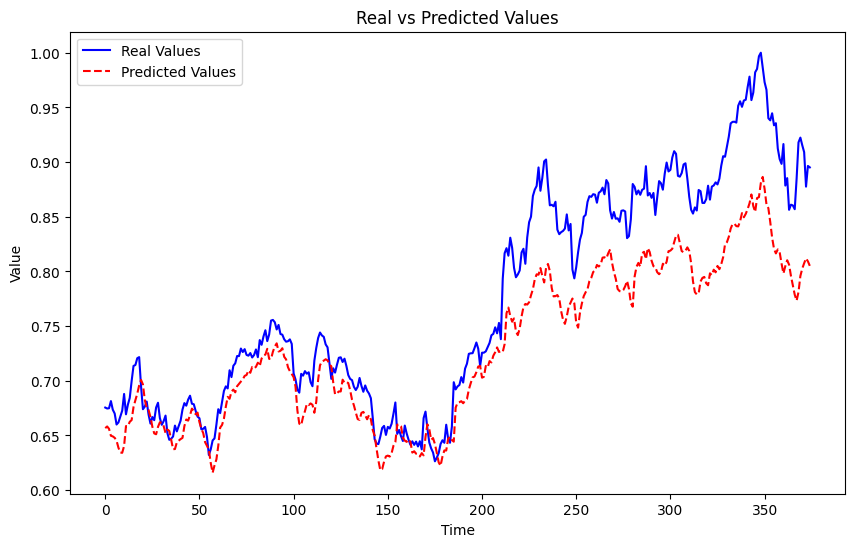

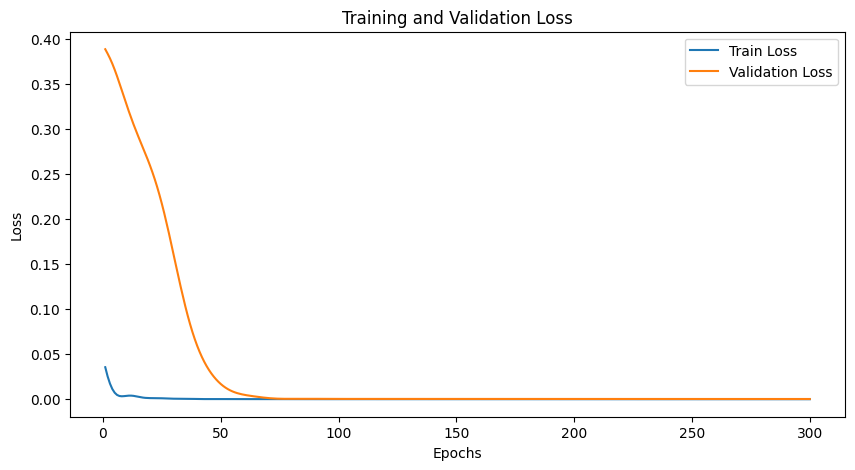

In [25]:
seed_everything(0)
sequence_length = 5    
input_channels = 11
lstm_hidden_size = 512
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 300

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'cnn_lstm_model_apple_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_5_cnn_lstm.png', train_losses, val_losses, num_epochs)

## Time step = 10

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/300:
Train RMSE: 0.0096, Train MAE: 0.0072
Val RMSE: 0.0197, Val MAE: 0.0159
Epoch 200/300:
Train RMSE: 0.0072, Train MAE: 0.0053
Val RMSE: 0.0170, Val MAE: 0.0135
Epoch 300/300:
Train RMSE: 0.0063, Train MAE: 0.0046
Val RMSE: 0.0159, Val MAE: 0.0123

Final Results:
Test RMSE: 0.0568
Test MAE: 0.0448


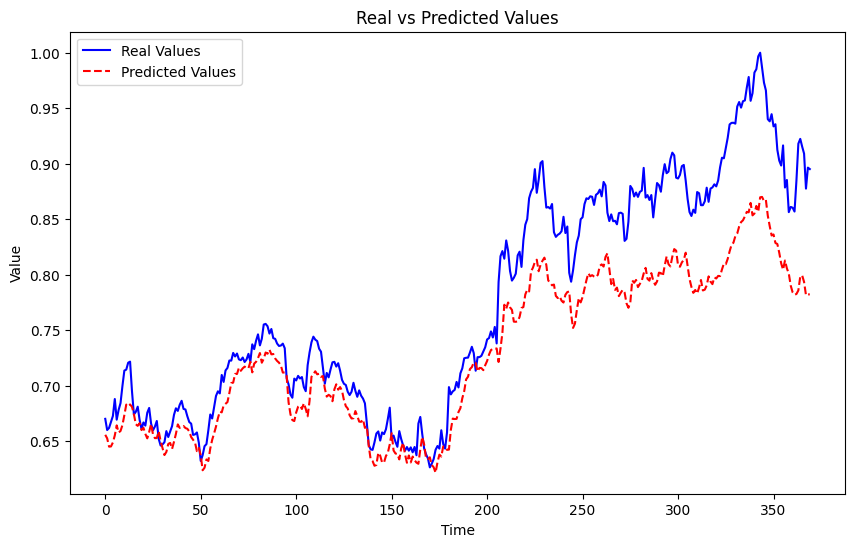

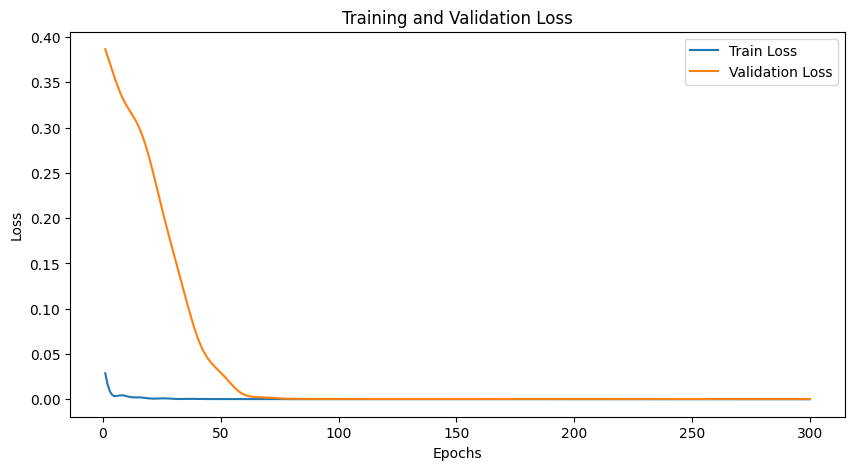

In [26]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 512
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 300

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'cnn_lstm_model_apple_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_5_cnn_lstm.png', train_losses, val_losses, num_epochs)

## Time step = 20

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/300:
Train RMSE: 0.0080, Train MAE: 0.0060
Val RMSE: 0.0169, Val MAE: 0.0133
Epoch 200/300:
Train RMSE: 0.0066, Train MAE: 0.0048
Val RMSE: 0.0162, Val MAE: 0.0126
Epoch 300/300:
Train RMSE: 0.0059, Train MAE: 0.0042
Val RMSE: 0.0157, Val MAE: 0.0121

Final Results:
Test RMSE: 0.0605
Test MAE: 0.0487


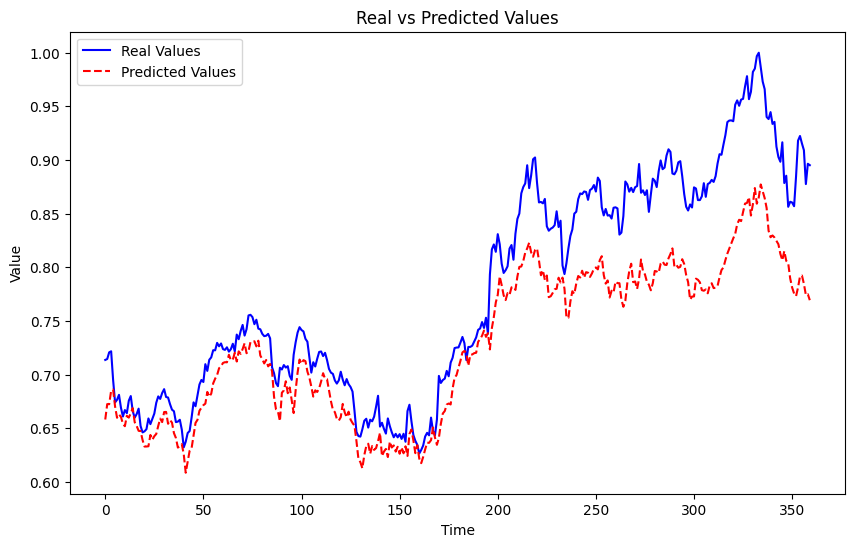

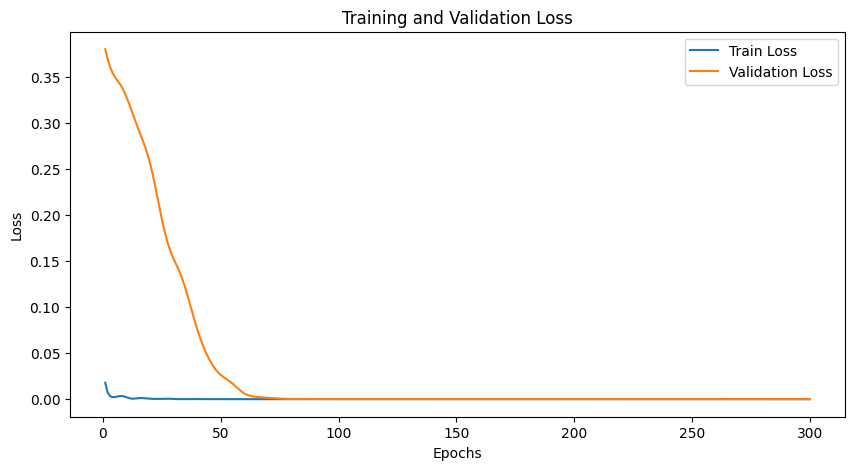

In [27]:
seed_everything(0)
sequence_length = 20    
input_channels = 11
lstm_hidden_size = 512
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 300

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'cnn_lstm_model_apple_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_20_cnn_lstm.png', train_losses, val_losses, num_epochs)

# META

In [28]:
data = pd.read_csv('/kaggle/input/meta-dataset/META_day.csv')
meta_stock = preprocessing(data)
meta_stock.tail()

<ipython-input-3-80cb02926627>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-80cb02926627>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
Date,,,,,,,,,,,,
2025-04-28,0.749487,0.748276,0.739388,0.740697,0.018375,0.906076,0.871400,0.441323,0.209590,0.057638,0.775363,0.712104
2025-04-29,0.736048,0.745617,0.744377,0.747239,0.012497,0.900351,0.870095,0.457564,0.262783,0.092388,0.770651,0.714116
2025-04-30,0.725454,0.735272,0.723713,0.739667,0.043101,0.895094,0.868506,0.437595,0.300065,0.128458,0.761696,0.718664
2025-05-01,0.800285,0.796000,0.781663,0.771976,0.046372,0.890966,0.868410,0.518210,0.362421,0.171143,0.758003,0.721092
2025-05-02,0.788261,0.805667,0.792730,0.805371,0.012139,0.887875,0.869796,0.588880,0.444745,0.223551,0.772604,0.714337


## LERNING RATE 

In [29]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0113, Train MAE: 0.0083
Val RMSE: 0.0176, Val MAE: 0.0134


In [30]:
seed_everything(0)
sequence_length = 5    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.00001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0396, Train MAE: 0.0319
Val RMSE: 0.0395, Val MAE: 0.0339


## HID SIZE

In [31]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 256
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0083, Train MAE: 0.0058
Val RMSE: 0.0116, Val MAE: 0.0089


In [32]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 512
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0084, Train MAE: 0.0058
Val RMSE: 0.0111, Val MAE: 0.0081


## NUMBER LAYERS

In [33]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 2
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.0139, Train MAE: 0.0102
Val RMSE: 0.0124, Val MAE: 0.0091


In [34]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 3
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.0139, Train MAE: 0.0097
Val RMSE: 0.0124, Val MAE: 0.0089


## DROPOUT META

In [35]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.1
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0072, Train MAE: 0.0049
Val RMSE: 0.0137, Val MAE: 0.0096


In [36]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0072, Train MAE: 0.0049
Val RMSE: 0.0137, Val MAE: 0.0096


## NUMBER EPOCHES

In [37]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 200

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/200:
Train RMSE: 0.0072, Train MAE: 0.0049
Val RMSE: 0.0137, Val MAE: 0.0096
Epoch 200/200:
Train RMSE: 0.0061, Train MAE: 0.0040
Val RMSE: 0.0114, Val MAE: 0.0081


In [38]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 300

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/300:
Train RMSE: 0.0072, Train MAE: 0.0049
Val RMSE: 0.0137, Val MAE: 0.0096
Epoch 200/300:
Train RMSE: 0.0061, Train MAE: 0.0040
Val RMSE: 0.0114, Val MAE: 0.0081
Epoch 300/300:
Train RMSE: 0.0056, Train MAE: 0.0037
Val RMSE: 0.0109, Val MAE: 0.0079


## STEP = 5

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/200:
Train RMSE: 0.0099, Train MAE: 0.0074
Val RMSE: 0.0196, Val MAE: 0.0155
Epoch 200/200:
Train RMSE: 0.0073, Train MAE: 0.0052
Val RMSE: 0.0181, Val MAE: 0.0140

Final Results:
Test RMSE: 0.0607
Test MAE: 0.0485


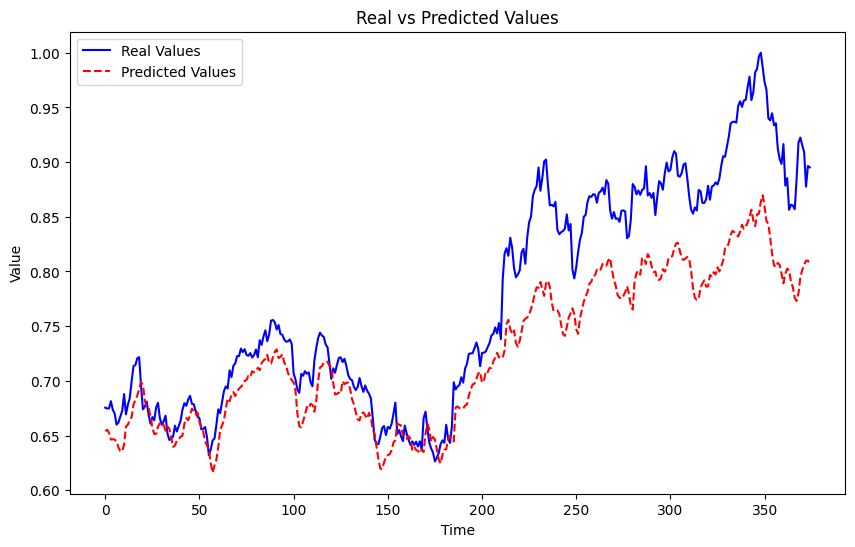

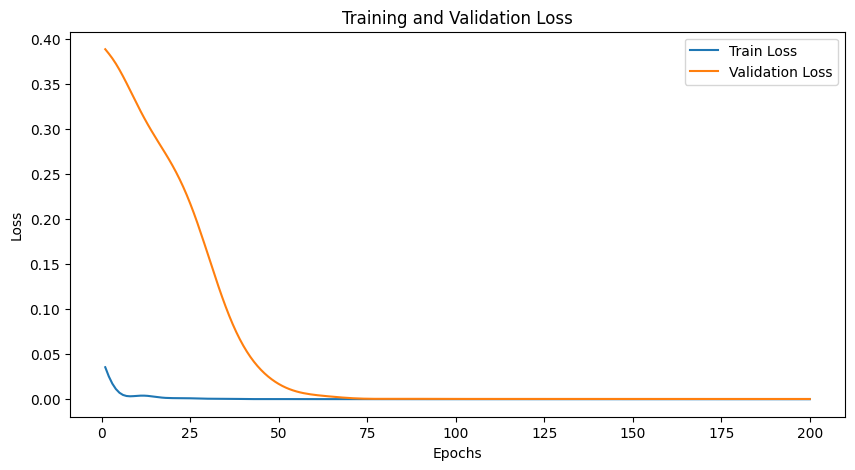

In [39]:
seed_everything(0)
sequence_length = 5    
input_channels = 11
lstm_hidden_size = 512
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'cnn_lstm_model_meta_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_5_cnn_lstm.png', train_losses, val_losses, num_epochs)

## STEP = 10

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/200:
Train RMSE: 0.0096, Train MAE: 0.0072
Val RMSE: 0.0197, Val MAE: 0.0159
Epoch 200/200:
Train RMSE: 0.0072, Train MAE: 0.0053
Val RMSE: 0.0170, Val MAE: 0.0135

Final Results:
Test RMSE: 0.0615
Test MAE: 0.0484


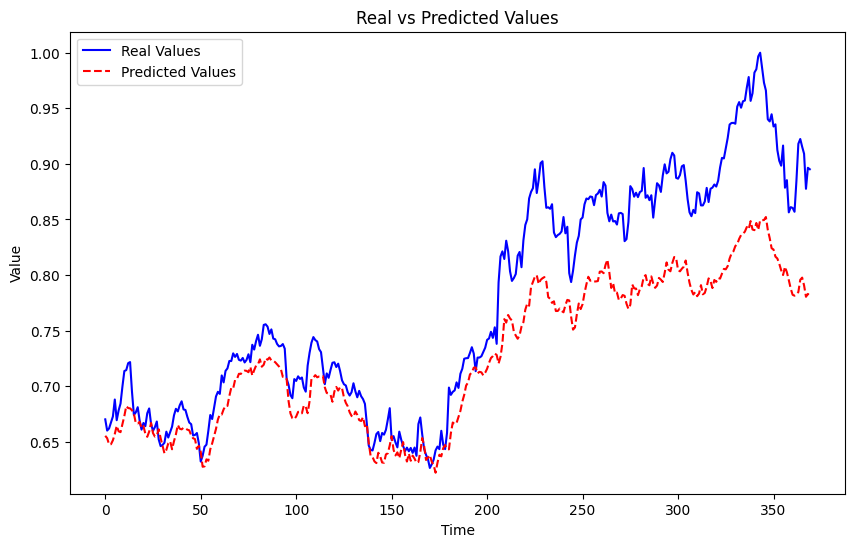

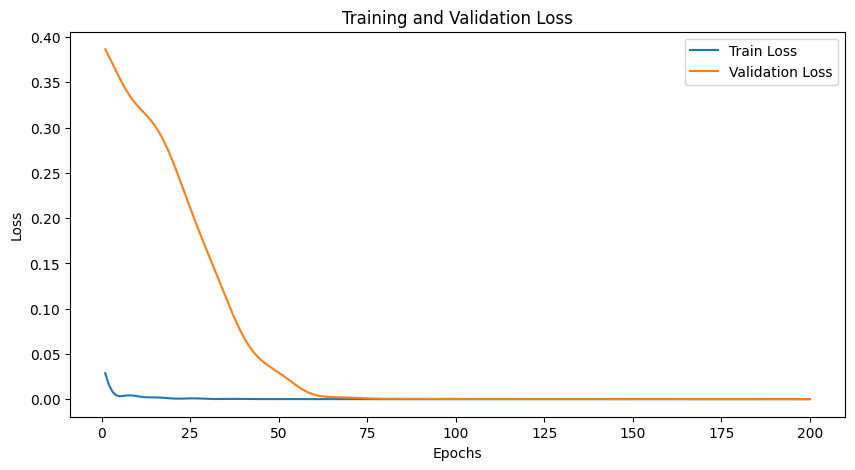

In [40]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 512
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'cnn_lstm_model_meta_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_10_cnn_lstm.png', train_losses, val_losses, num_epochs)

## STEP = 20

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/200:
Train RMSE: 0.0080, Train MAE: 0.0060
Val RMSE: 0.0169, Val MAE: 0.0133
Epoch 200/200:
Train RMSE: 0.0066, Train MAE: 0.0048
Val RMSE: 0.0162, Val MAE: 0.0126

Final Results:
Test RMSE: 0.0649
Test MAE: 0.0524


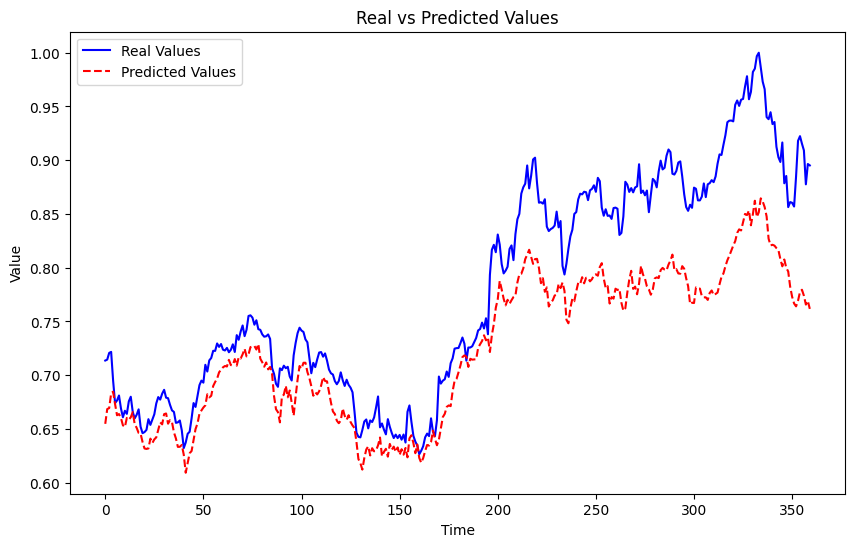

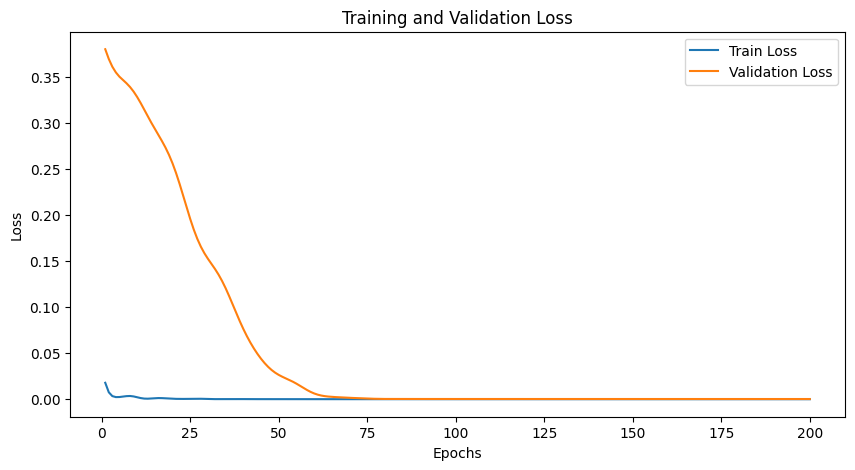

In [41]:
seed_everything(0)
sequence_length = 20    
input_channels = 11
lstm_hidden_size = 512
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'cnn_lstm_model_meta_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_20_cnn_lstm.png', train_losses, val_losses, num_epochs)

# TESLA

In [42]:
data = pd.read_csv('/kaggle/input/tesla-dataset/Tesla_day.csv')
tesla_stock = preprocessing(data)
tesla_stock.tail()

<ipython-input-3-80cb02926627>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-80cb02926627>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
Date,,,,,,,,,,,,
2025-04-28,0.606338,0.602652,0.594556,0.594868,0.164369,0.668509,0.714936,0.538552,0.452898,0.377682,0.586609,0.570638
2025-04-29,0.599009,0.599492,0.609999,0.607712,0.117427,0.665325,0.716542,0.559510,0.488656,0.403206,0.597159,0.565613
2025-04-30,0.587215,0.581295,0.590963,0.587099,0.139409,0.661734,0.717078,0.510602,0.506086,0.427586,0.601176,0.564011
2025-05-01,0.587447,0.594466,0.610743,0.583673,0.107290,0.657739,0.717427,0.502496,0.517583,0.449703,0.600390,0.564440
2025-05-02,0.597746,0.602488,0.610743,0.597646,0.123125,0.654385,0.718443,0.529324,0.533031,0.470906,0.606345,0.561966


## Learning rate

In [43]:
seed_everything(0)
sequence_length = 5    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0138, Train MAE: 0.0078
Val RMSE: 0.0293, Val MAE: 0.0232


In [44]:
seed_everything(0)
sequence_length = 5    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.00001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0542, Train MAE: 0.0320
Val RMSE: 0.0909, Val MAE: 0.0765


## Hidden size

In [45]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 256
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0123, Train MAE: 0.0062
Val RMSE: 0.0249, Val MAE: 0.0198


In [46]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 512
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0116, Train MAE: 0.0061
Val RMSE: 0.0214, Val MAE: 0.0170


## Number layers

In [47]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 2
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.0167, Train MAE: 0.0088
Val RMSE: 0.0230, Val MAE: 0.0183


## Dropout

In [48]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.1
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0099, Train MAE: 0.0050
Val RMSE: 0.0248, Val MAE: 0.0194


In [49]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.001
num_epochs = 100

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/100:
Train RMSE: 0.0099, Train MAE: 0.0050
Val RMSE: 0.0248, Val MAE: 0.0194


## Number epoches

In [50]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 200

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/200:
Train RMSE: 0.0099, Train MAE: 0.0050
Val RMSE: 0.0248, Val MAE: 0.0194
Epoch 200/200:
Train RMSE: 0.0081, Train MAE: 0.0040
Val RMSE: 0.0239, Val MAE: 0.0182


In [51]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 128
lstm_layers = 1
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 300

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 100/300:
Train RMSE: 0.0099, Train MAE: 0.0050
Val RMSE: 0.0248, Val MAE: 0.0194
Epoch 200/300:
Train RMSE: 0.0081, Train MAE: 0.0040
Val RMSE: 0.0239, Val MAE: 0.0182
Epoch 300/300:
Train RMSE: 0.0072, Train MAE: 0.0035
Val RMSE: 0.0245, Val MAE: 0.0184


## Time Step = 5

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/200:
Train RMSE: 0.0144, Train MAE: 0.0085
Val RMSE: 0.0315, Val MAE: 0.0247
Epoch 200/200:
Train RMSE: 0.0117, Train MAE: 0.0063
Val RMSE: 0.0270, Val MAE: 0.0208

Final Results:
Test RMSE: 0.0397
Test MAE: 0.0281


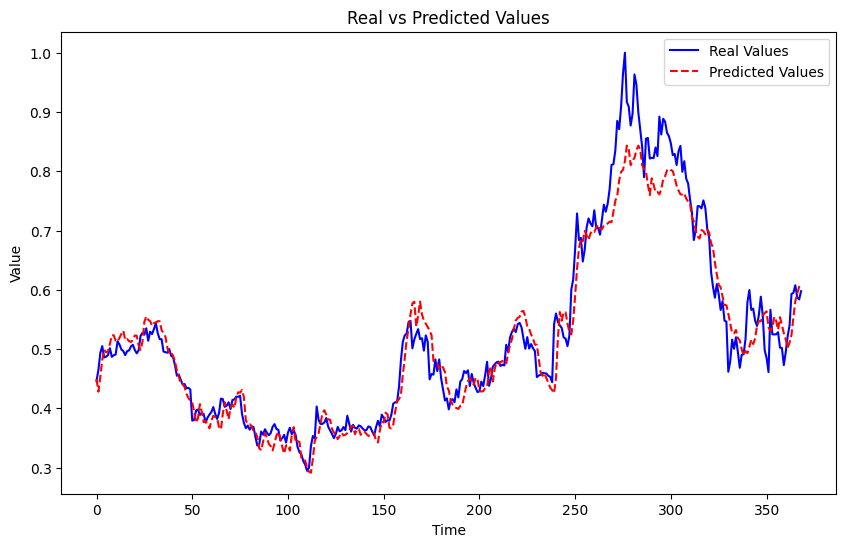

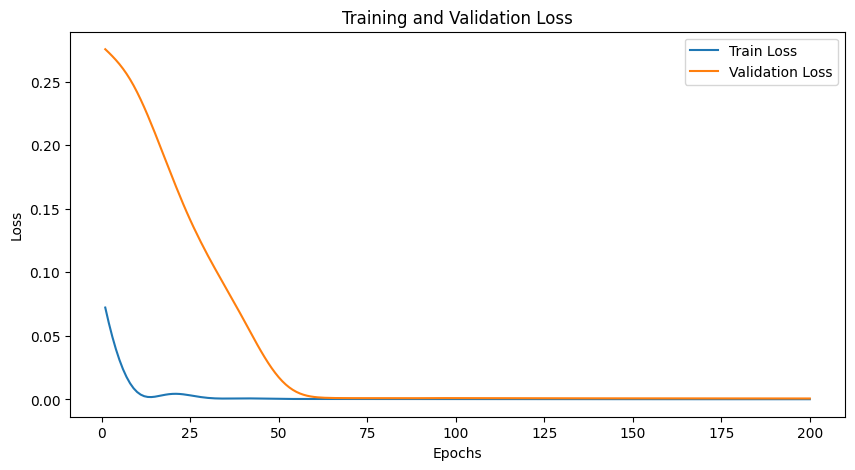

In [52]:
seed_everything(0)
sequence_length = 5    
input_channels = 11
lstm_hidden_size = 256
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'cnn_tesla_lstm_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_lstm_step_5_cnn.png', train_losses, val_losses, num_epochs)

## Time Step = 10

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/200:
Train RMSE: 0.0155, Train MAE: 0.0093
Val RMSE: 0.0324, Val MAE: 0.0263
Epoch 200/200:
Train RMSE: 0.0128, Train MAE: 0.0075
Val RMSE: 0.0269, Val MAE: 0.0211

Final Results:
Test RMSE: 0.0422
Test MAE: 0.0299


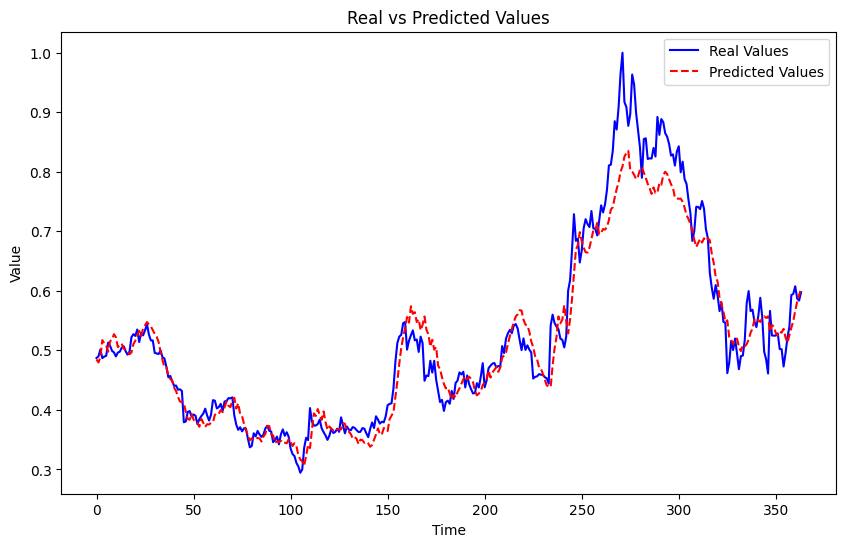

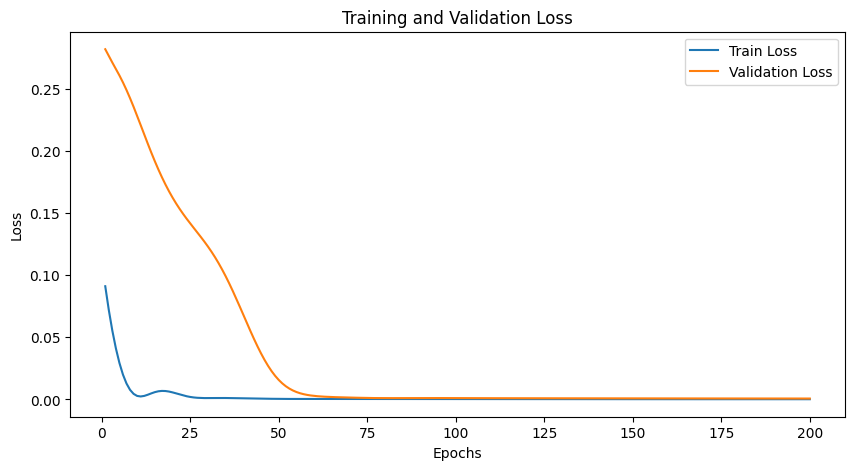

In [53]:
seed_everything(0)
sequence_length = 10    
input_channels = 11
lstm_hidden_size = 256
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'cnn_model_tesla_lstm_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_10_cnn_lstm.png', train_losses, val_losses, num_epochs)

## Time Step = 20

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 100/200:
Train RMSE: 0.0146, Train MAE: 0.0093
Val RMSE: 0.0286, Val MAE: 0.0216
Epoch 200/200:
Train RMSE: 0.0121, Train MAE: 0.0075
Val RMSE: 0.0258, Val MAE: 0.0194

Final Results:
Test RMSE: 0.0373
Test MAE: 0.0277


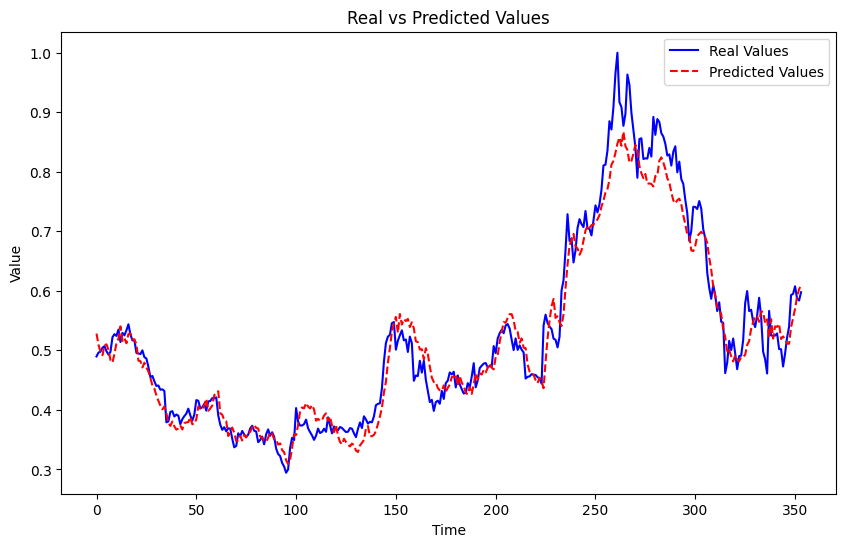

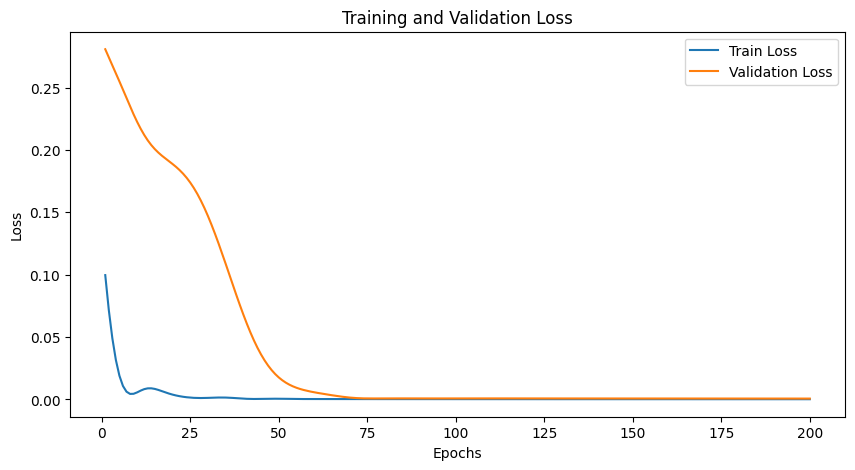

In [54]:
seed_everything(0)
sequence_length = 20    
input_channels = 11
lstm_hidden_size = 256
lstm_layers = 1 
dropout_rate = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = CNN_LSTM(input_channels,sequence_length, lstm_hidden_size, lstm_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'cnn_model_tesla_lstm_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_20_cnn_lstm.png', train_losses, val_losses, num_epochs)